<h1>Dataloading</h1>

In [1]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism


def prepare(in_dir, imaging_index, pixdim=(1.0, 1.0, 1.0), a_min=0, a_max=503, spatial_size=[128,128,144], trainloader_batchsize=1):
    print("Preparing...")
    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, f"images_{imaging_index}", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "segmentation", "*.nii.gz")))

    '''DEBUG'''
    print(f"Length of path_train_volumes: {len(path_train_volumes)}")    
    print(f"Length of path_train_segmentation: {len(path_train_segmentation)}")    
    '''DEBUG'''

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
    train_loader = DataLoader(train_ds, batch_size=trainloader_batchsize)
    print("Preparing done.")

    return train_loader



In [2]:
training_directory="D:/MLDatasets/TCGA-GBM Datasets/Training"

'''CHANGE IMAGING INDEX FOR TYPE OF MRI'''
imaging_index=0 # Use FLAIR as main
data_f = prepare(in_dir=training_directory, imaging_index=imaging_index)

trainloader = data_f

Preparing...
Length of path_train_volumes: 102
Length of path_train_segmentation: 102


Loading dataset: 100%|██████████| 102/102 [01:33<00:00,  1.09it/s]

Preparing done.


<h1>Data Imaging</h1>

Image shape is: torch.Size([1, 1, 144, 144, 144])
Label shape is: torch.Size([1, 1, 144, 144, 144])


C:\Users\steve\AppData\Local\Temp\ipykernel_6584\1825279634.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(90, 100)):


  0%|          | 0/10 [00:00<?, ?it/s]

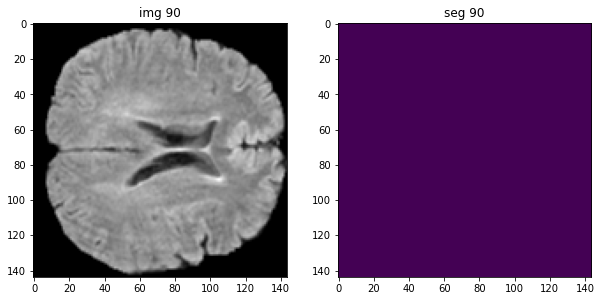

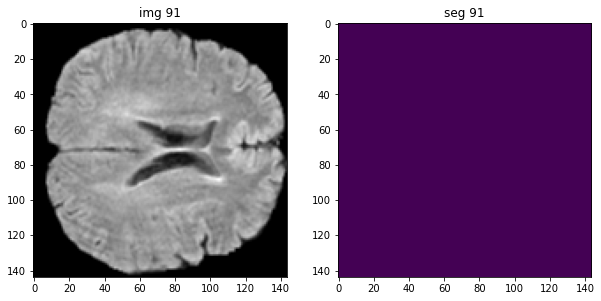

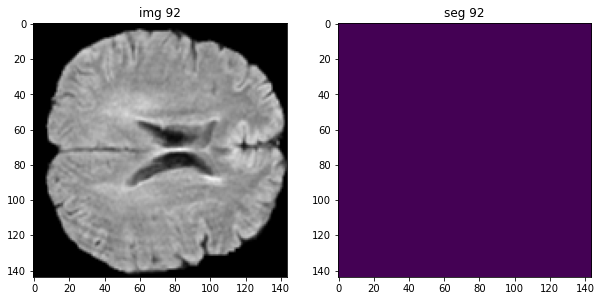

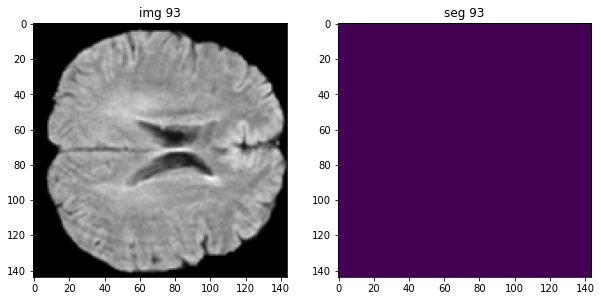

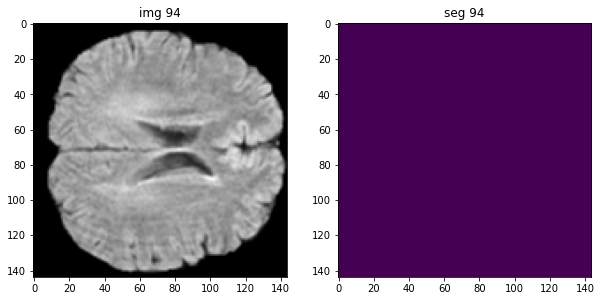

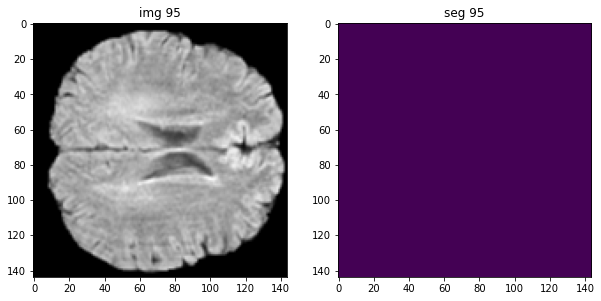

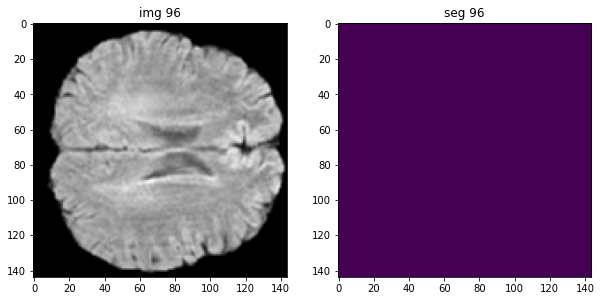

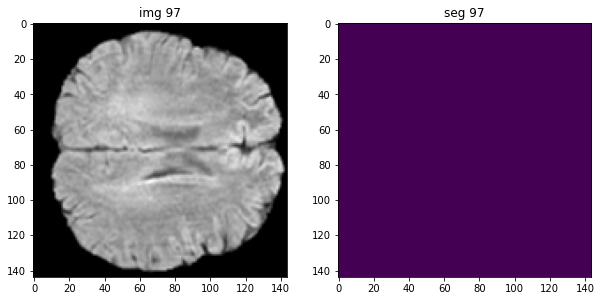

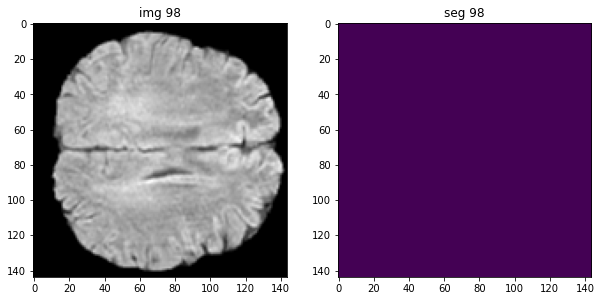

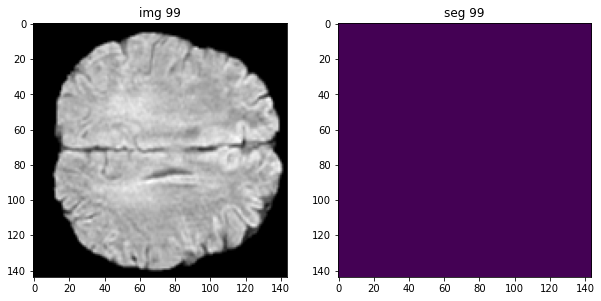

In [3]:
from monai.utils import first
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
firstdata = first(trainloader)
print(f"Image shape is: {firstdata['vol'].shape}")
print(f"Label shape is: {firstdata['seg'].shape}")

for i in tqdm_notebook(range(90, 100)):
    plt.figure("Training NIFTI", (10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"img {i}")
    plt.imshow(firstdata['vol'][0, 0, :, :, i], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"seg {i}")
    plt.imshow(firstdata['seg'][0, 0, :, :, i])
    plt.show()

<h1>Training</h1>

In [4]:
model_storage = "D:/MLDatasets/TCGA-GBM Datasets/Models"

<h3>UNET Definition</h3>

In [5]:
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from monai.networks.nets.attentionunet import AttentionUnet
from monai.networks.layers import Norm 
from monai.losses import DiceLoss

from torchvision import transforms
from torch.utils.data import DataLoader, random_split


class AttUNETTransfer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = AttentionUnet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256), 
            strides=(2, 2, 2, 2),
        )
        self.loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)

    def training_step(self, batch, batch_idx):
        vol, seg = batch['vol'], batch['seg']
        out = self.model(vol)
        res_loss = self.loss(out, vol)
        self.log('train loss',  res_loss)
        return res_loss 
     
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

test_model = AttUNETTransfer()
print(test_model.model)

AttentionUnet(
  (model): Sequential(
    (0): ConvBlock(
      (conv): Sequential(
        (0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
        (1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): ReLU()
          )
        )
      )
    )
    (1): AttentionLayer(
      (attention): AttentionBlock(
        (W_g): Sequential(
          (0): Convolution(
            (conv): Conv3d(16, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1))
          )
          (1): BatchNorm3d(8, eps=1e-05

In [6]:
print(f"Trainloader Length: {len(trainloader)}")

Trainloader Length: 102


In [7]:
torch.cuda.empty_cache()

In [8]:
model = AttUNETTransfer()

'''SET TRAINING EPOCHS'''
EPOCHS = 30 
USING_CHECKPOINT = False
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=EPOCHS)

if(USING_CHECKPOINT is True):
    last_checkpoint = './lightning_logs/version_12/checkpoints/epoch=14-step=1530.ckpt'
    trainer.fit(model=model, train_dataloaders=trainloader, ckpt_path=last_checkpoint)
else:
    trainer.fit(model=model, train_dataloaders=trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | AttentionUnet | 5.9 M 
1 | loss  | DiceLoss      | 0     
----------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.636    Total estimated model params size (MB)
c:\Users\steve\anaconda3\envs\pytorchMain\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\Users\steve\anaconda3\envs\pytorchMain\lib\site-packages\monai\losses\dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


RuntimeError: Unable to find a valid cuDNN algorithm to run convolution